In [13]:
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import os

import inferno
from inferno.utils import to_numpy

from sine_data import train_dataset, valid_dataset
import insp

In [14]:
X_train, y_train = train_dataset()
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset()
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [15]:
writer = SummaryWriter()

## Components

(0, 1)

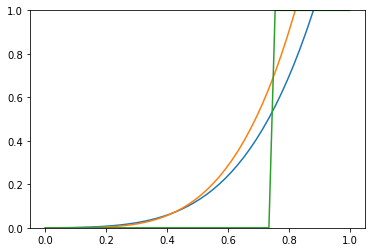

In [16]:
x = np.linspace(0,1)
plt.plot(x, 3/2 * x**4 + 1/8 * x**2)
plt.plot(x, 2.2 * x**4 )
plt.plot(x, x >= 0.75)
plt.ylim([0,1])

In [17]:
class Latch(nn.Module):

    def __init__(self, size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.act = nn.Hardtanh(min_val=0, max_val=1)
        #self.consent_threshold = 0.75
        self.size = size
        
    def initial_q(self, batch_size):
        q = torch.zeros((batch_size, self.size))
        return Variable(q)

    def t(self, s):
        # all inputs in s must say 'store' or otherwise
        # there is no consent to store an value.
        #
        # we want that 
        # - most of the inputs agree
        # - the result is between 0 and 1 so we can use it as gate
        # - we want it to be differentiable and soft (well behaved gradients)
        x = s.sum(-1) / s.size(-1)
        return self.act(3/2 * x**4 + 1/8 * x**2)
        #return (self.act(s).mean(-1) >= self.consent_threshold).float()

    def forward(self, s, v, q):
        t = self.t(s).unsqueeze(-1)
        new_q = v * t + q * (1 - t)
        return new_q

In [18]:
class Block(nn.Module):
    def __init__(self, input_dim, output_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_units = output_dim

        self.latch_size = self.num_units
        self.latch = Latch(self.latch_size)

        self.units = nn.Linear(input_dim, output_dim)
        self.memory = nn.Linear(self.latch_size, self.num_units)
        self.set = nn.Parameter(torch.zeros(self.num_units) + 0.0)
        self.value = nn.Linear(self.num_units, self.latch_size)

        self.act = nn.Tanh()

    def forward(self, x):
        # x.shape = (b, t, u)
        t = x.size(1)
        acts = []
        qs = []
        q = self.latch.initial_q(x.size(0))
        for ti in range(t):
            u = self.units(x[:,ti])
            v = u + self.memory(q)
            q = self.latch(u, self.value(v), q)
            acts += [self.act(v)]
            qs += [q]
        return torch.stack(acts, dim=1), torch.stack(qs, dim=1)

In [19]:
class BlockLayer(nn.Module):
    def __init__(self, num_blocks, input_dim, output_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_blocks = num_blocks
        self.units_per_block = output_dim // num_blocks
        self.blocks = [Block(input_dim=input_dim,
                             output_dim=self.units_per_block)
                       for _ in range(num_blocks)]
        for i in range(len(self.blocks)):
            self.add_module('block_{}'.format(i), self.blocks[i])

    def forward(self, x):
        results = [block(x) for block in self.blocks]
        acts = [n[0] for n in results]
        qs = [n[1] for n in results]
        return torch.cat(acts, dim=-1), torch.cat(qs, dim=-1)

## Model

In [20]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

# Sine Wave Reconstruction

In [21]:
class ReconBlockModel(nn.Module):
    def __init__(self, *args, baseline=False, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.baseline = baseline

        self.layer0_mem = BlockLayer(num_blocks=10,
                                     input_dim=1,
                                     output_dim=20)
        self.layer0_clf = nn.Linear(1 + 20, 20)
        
        self.layer1 = nn.Linear(20,1)
        self.gru = nn.GRU(1, 20)
        self.iter = 0

    def forward(self, x):
        if not self.baseline:
            o0, q0 = self.layer0_mem(x)
            writer.add_histogram('q0', q0.data.cpu().numpy(), self.iter)
            self.iter += 1
            merged0 = torch.cat([x, q0], dim=-1)
            
            l0_clf = self.layer0_clf(time_flatten(merged0))
        else:
            l0_clf = time_flatten(self.gru(x)[0])
        
        l1 = self.layer1(l0_clf)
        
        return time_unflatten(l1, x.size())

In [22]:
class ReconTrainer(inferno.NeuralNet):
    
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        self.iter = 0
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)
    
    def train_step(self, *args, **kwargs):
        for name, param in self.module_.named_parameters():
            writer.add_histogram(name, param.data.cpu().numpy(), self.iter)
        self.iter += 1
        return super().train_step(*args, **kwargs)

## Training

In [23]:
def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef = ReconTrainer(module=ReconBlockModel,
             optim=torch.optim.RMSprop,
             lr=0.005,
             max_epochs=10,
             module__baseline=False,
             train_split=my_train_split,
             gradient_clip_value=10,
            )

In [24]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8333        0.1026  2.5667
      2        0.2702        0.3537  2.6003
      3        1.0708        0.2207  2.5432
      4        0.2452        0.0887  2.6631
      5        0.1392        0.0628  2.5810
      6        0.1161        0.0550  2.6774
      7        0.1035        0.0489  2.7004
      8        0.0932        0.0439  2.6830
      9        0.0845        0.0397  2.6520
     10        0.0770        0.0361  2.7068
     11        0.0705        0.0329  2.6552
     12        0.0648        0.0301  2.9037
     13        0.0597        0.0276  2.9239
     14        0.0552        0.0254  2.7082
     15        0.0511        0.0234  2.5066
     16        0.0474        0.0215  2.8445
     17        0.0441        0.0199  2.9225
     18        0.0411        0.0184  2.7190
     19        0.0384        0.0170  2.7791
     20        0.0359        0.0157

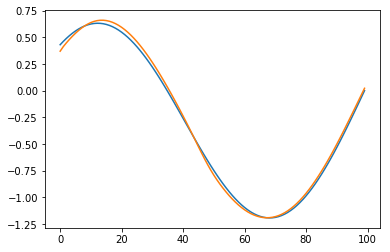

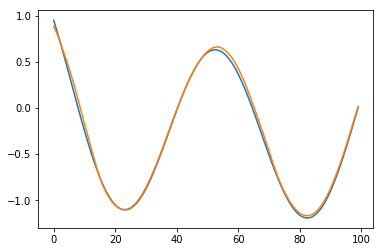

In [25]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])